In [1]:
import sys
print(sys.executable)

/data/leuven/351/vsc35109/miniconda3/envs/total-env/bin/python


In [2]:
import tempfile
import muon as mu
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import scanpy as sc
import scvi
import seaborn as sns
import torch

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.2.0


# Raw data

In [3]:
import os
adata_ADT = sc.read_csv("/scratch/leuven/351/vsc35109/Mowgli_data/PBMC/GSM4949911_tea_fulldepth_adt_counts.csv.gz")
adata_RNA_ATAC = sc.read_10x_h5("/scratch/leuven/351/vsc35109/Mowgli_data/PBMC/GSM4949911_X061-AP0C1W1_leukopak_perm-cells_tea_fulldepth_cellranger-arc_filtered_feature_bc_matrix.h5",gex_only=False)
mdata_RNA_ATAC = mu.read_10x_h5("/scratch/leuven/351/vsc35109/Mowgli_data/PBMC/GSM4949911_X061-AP0C1W1_leukopak_perm-cells_tea_fulldepth_cellranger-arc_filtered_feature_bc_matrix.h5")
# Remove the "total" feature.
adata_ADT = adata_ADT[:, 1:]
# Make index of proteins compatible with 10X multiome.
adata_ADT.obs.index += "-1"
# Fuse everything.
mdata = mu.MuData({"rna": mdata_RNA_ATAC["rna"], "atac": mdata_RNA_ATAC["atac"], "adt": adata_ADT})

# Make variable names unique.
mdata.var_names_make_unique()

# Keep only cell with all modalities.
# (proteins in particular has a lot of background).
mu.pp.intersect_obs(mdata)
adata_ADT=mdata["adt"]



/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /scratch/leuven/351/vsc35109/Mowgli_data/PBMC/GSM4949911_X061-AP0C1W1_leukopak_perm-cells_tea_fulldepth_cellranger-arc_filtered_feature_bc_matrix.h5


/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-pac

In [4]:
print(adata_RNA_ATAC)
print(adata_ADT)

AnnData object with n_obs × n_vars = 8213 × 103429
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
AnnData object with n_obs × n_vars = 8213 × 46


In [5]:
adata_RNA_ATAC.var_names_make_unique()

# Concatenate mudata

In [6]:
# Load the data.
mdata_TEA = md.read_h5mu("/scratch/leuven/351/vsc35109/Mowgli_data/PBMC/GSM4949911_tea_preprocessed.h5mu.gz")

/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [7]:
mdata_TEA

MuData object with n_obs × n_vars = 7084 × 17546
  var:	'highly_variable'
  3 modalities
    rna:	7084 x 2500
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'log1p'
      layers:	'counts'
    atac:	7084 x 15000
      obs:	'n_genes_by_counts', 'total_counts', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'Chromosome', 'Range', 'Start', 'End', 'Length', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'log1p'
      layers:	'counts'
    adt:	7084 x 46
      obs:	'celltype'
      var:	'highly_variable'
      layers:	'counts'

In [8]:
adata_RNA = mdata_TEA.mod['rna']
adata_ATAC = mdata_TEA.mod['atac']
adata_ADT = mdata_TEA.mod['adt']

In [9]:
import anndata as ad
import pandas as pd
matrix_data=adata_ADT.X
df = pd.DataFrame(data=matrix_data, index=adata_ADT.obs_names, columns=adata_ADT.var_names)

In [10]:
adata_RNA.obsm["protein_expression"]=df
adata_ATAC.obsm["protein_expression"]=df

In [11]:
adata_paired = ad.concat([adata_RNA, adata_ATAC], join="outer", axis=1, label="modality", index_unique="-")
adata_paired

AnnData object with n_obs × n_vars = 7084 × 17500
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Chromosome', 'Range', 'Start', 'End', 'Length', 'modality'
    layers: 'counts'

In [12]:
#adata_var = ad.concat([adata_RNA, adata_ATAC], join="inner", axis=1)
#adata_paired.var = adata_var.var
adata_paired.var

,gene_ids,feature_types,genome,interval,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,Chromosome,Range,Start,End,Length,modality
rna:C1orf159-0,ENSG00000131591,Gene Expression,GRCh38,chr1:1092173-1116098,False,489,0.073907,94.046025,607.0,True,0.193740,1.546596,1.171425,NaN,NaN,NaN,NaN,NaN,0
rna:AL109917.1-0,ENSG00000231050,Gene Expression,GRCh38,chr1:1891470-1891471,False,11,0.001339,99.866066,11.0,True,0.003477,1.470601,0.859363,NaN,NaN,NaN,NaN,NaN,0
rna:SKI-0,ENSG00000157933,Gene Expression,GRCh38,chr1:2228318-2228319,False,4933,1.848168,39.936686,15179.0,True,1.885655,2.334640,1.442383,NaN,NaN,NaN,NaN,NaN,0
rna:PLCH2-0,ENSG00000149527,Gene Expression,GRCh38,chr1:2467458-2476315,False,160,0.021064,98.051869,173.0,True,0.066893,1.506222,1.005634,NaN,NaN,NaN,NaN,NaN,0
rna:PRDM16-0,ENSG00000142611,Gene Expression,GRCh38,chr1:3069167-3069211,False,16,0.003775,99.805187,31.0,True,0.009350,2.119619,3.524437,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
atac:GL000219.1:51047-51299-1,GL000219.1:51047-51299,Peaks,GRCh38,GL000219.1:51047-51299,<NA>,22,0.004018,99.732132,33.0,True,0.006048,1.547211,1.248002,GL000219.1,51047-51299,51047.0,51299.0,252.0,1
atac:KI270721.1:2332-2746-1,KI270721.1:2332-2746,Peaks,GRCh38,KI270721.1:2332-2746,<NA>,122,0.030074,98.514550,247.0,True,0.043806,1.497691,1.120204,KI270721.1,2332-2746,2332.0,2746.0,414.0,1
atac:KI270726.1:27354-27791-1,KI270726.1:27354-27791,Peaks,GRCh38,KI270726.1:27354-27791,<NA>,144,0.033484,98.246682,275.0,True,0.058276,1.631249,1.400783,KI270726.1,27354-27791,27354.0,27791.0,437.0,1
atac:KI270726.1:41733-42164-1,KI270726.1:41733-42164,Peaks,GRCh38,KI270726.1:41733-42164,<NA>,135,0.029344,98.356264,241.0,True,0.052593,1.591489,1.190786,KI270726.1,41733-42164,41733.0,42164.0,431.0,1


In [13]:
adata_paired

AnnData object with n_obs × n_vars = 7084 × 17500
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Chromosome', 'Range', 'Start', 'End', 'Length', 'modality'
    layers: 'counts'

In [14]:
#del df
#del adata_RNA
#del adata_ATAC
#del adata_ADT

In [15]:
adata_paired = adata_paired[:, adata_paired.var["feature_types"].argsort()].copy()
adata_paired.obs

""
AAACAGCCAATTAGGA-1
AAACAGCCACGTAAGG-1
AAACAGCCACTAAGAA-1
AAACATGCAAAGGCCA-1
AAACATGCAACTAACT-1
...
TTTGTTGGTCATAACG-1
TTTGTTGGTGATTACG-1
TTTGTTGGTTAGAGGG-1
TTTGTTGGTTATAGCG-1


In [16]:
import numpy as np
adata_paired.obs["modality"] = np.zeros(7084, dtype=int)
adata_paired.obs

,modality
AAACAGCCAATTAGGA-1,0
AAACAGCCACGTAAGG-1,0
AAACAGCCACTAAGAA-1,0
AAACATGCAAAGGCCA-1,0
AAACATGCAACTAACT-1,0
...,...
TTTGTTGGTCATAACG-1,0
TTTGTTGGTGATTACG-1,0
TTTGTTGGTTAGAGGG-1,0
TTTGTTGGTTATAGCG-1,0


In [17]:
import numpy as np
adata_paired.X = np.nan_to_num(adata_paired.X, nan=0.0)

In [18]:
adata_paired.obsm["protein_expression"]=df

In [19]:
adata_paired

AnnData object with n_obs × n_vars = 7084 × 17500
    obs: 'modality'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Chromosome', 'Range', 'Start', 'End', 'Length', 'modality'
    obsm: 'protein_expression'
    layers: 'counts'

In [20]:
scvi.model.MULTIVI.setup_anndata(adata_paired, protein_expression_obsm_key="protein_expression", batch_key="modality")

INFO     Using column names from columns of adata.obsm['protein_expression']                                       


/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.obsm['protein_expression'] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [21]:
model = scvi.model.MULTIVI(
    adata_paired,
    n_genes=(adata_paired.var["feature_types"] == "Gene Expression").sum(),
    n_regions=(adata_paired.var["feature_types"] == "Peaks").sum(),
)
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': 'protein_expression',
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 7084  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│        n_proteins        │  46   │
│          n_vars          │ 17500 │
└──────────────────────────┴───────┘

                   Data Registry                   
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃       scvi-tools Location        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │             adata.X              │
│    batch     │     adata.obs['_scvi_batch']     │
│    ind_x     │      adata.obs['_indices']       │
│    labels    │    adata.obs['_scvi_labels']     │
│   proteins   │ adata.obsm['protein_expression'] │
└──────────────┴──────────────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │     0      │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │     0      │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [22]:
model.train()

/tmp/ipykernel_1083736/1676823408.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/model/_multivi.py:343: UserWarning: Disabling adversarial classifier.
  training_plan = self._training_plan_cls(self.module, **plan_kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/module/_multivae.py:870: UserWarning: The value argument must be within the support of the distribution
  .log_prob(x)
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/module/_multivae.py:1012: UserWarning: The value argument must be within the support of the distribution
  reconst_loss_protein_full = -py_conditional.log_prob(y)
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/module/_multivae.py:870: UserWarning: The value argument must be within the support of the distribution
  .log_prob(x)
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/module/_multivae.py:1012: UserWarning: The value argument must be within the support of the distribution
  reconst_loss_protein_full = -py_conditional.log_prob(y)
/data/leuven/351/vsc35109/miniconda3/envs/total-env/lib/python3.11/site-packages/scvi/module

In [29]:
model.save("trained_tea")

# Raw data

In [23]:
adata_mvi = scvi.data.organize_multiome_anndatas(adata_RNA_ATAC)

In [24]:
adata_mvi.obs

,modality
AAACAGCCAAGGGTTG-1_paired,paired
AAACAGCCAATTAGGA-1_paired,paired
AAACAGCCACGTAAGG-1_paired,paired
AAACAGCCACTAAGAA-1_paired,paired
AAACAGCCAGCCGCTA-1_paired,paired
...,...
TTTGTTGGTCATAACG-1_paired,paired
TTTGTTGGTGATTACG-1_paired,paired
TTTGTTGGTTAGAGGG-1_paired,paired
TTTGTTGGTTATAGCG-1_paired,paired


In [25]:
adata_mvi = adata_mvi[:, adata_mvi.var["feature_types"].argsort()].copy()
adata_mvi.var

,gene_ids,feature_types,genome,interval
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,chr1:29553-30267
AL391261.2,ENSG00000258847,Gene Expression,GRCh38,chr14:66004522-66004523
FUT8-AS1,ENSG00000276116,Gene Expression,GRCh38,chr14:65412689-65412690
FUT8,ENSG00000033170,Gene Expression,GRCh38,chr14:65410591-65413008
AL355076.2,ENSG00000258760,Gene Expression,GRCh38,chr14:65302679-65318790
...,...,...,...,...
chr15:100383854-100384150,chr15:100383854-100384150,Peaks,GRCh38,chr15:100383854-100384150
chr15:100394892-100395087,chr15:100394892-100395087,Peaks,GRCh38,chr15:100394892-100395087
chr15:100515856-100516094,chr15:100515856-100516094,Peaks,GRCh38,chr15:100515856-100516094
chr15:100559297-100559770,chr15:100559297-100559770,Peaks,GRCh38,chr15:100559297-100559770


In [26]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(8213, 103429)
(8213, 64009)


In [27]:
adata_ADT.obs_names = adata_ADT.obs_names + "_paired"
matrix_data=adata_ADT.X
df = pd.DataFrame(data=matrix_data, index=adata_ADT.obs_names, columns=adata_ADT.var_names)
adata_mvi.obsm['protein_expression'] = df 

ValueError: value.index does not match parent’s obs names:
Index are different

Index length are different
[left]:  7084, Index(['AAACAGCCAATTAGGA-1_paired', 'AAACAGCCACGTAAGG-1_paired',
       'AAACAGCCACTAAGAA-1_paired', 'AAACATGCAAAGGCCA-1_paired',
       'AAACATGCAACTAACT-1_paired', 'AAACATGCACAGGAAT-1_paired',
       'AAACATGCACGTAATT-1_paired', 'AAACATGCACTGGCTG-1_paired',
       'AAACATGCATAATGAG-1_paired', 'AAACATGCATCGCTCC-1_paired',
       ...
       'TTTGTGAAGTCAATCA-1_paired', 'TTTGTGTTCACCTGCT-1_paired',
       'TTTGTGTTCCCTGGAA-1_paired', 'TTTGTGTTCGCTAAAC-1_paired',
       'TTTGTGTTCTGTGAGT-1_paired', 'TTTGTTGGTCATAACG-1_paired',
       'TTTGTTGGTGATTACG-1_paired', 'TTTGTTGGTTAGAGGG-1_paired',
       'TTTGTTGGTTATAGCG-1_paired', 'TTTGTTGGTTTAAAGC-1_paired'],
      dtype='object', length=7084)
[right]: 8213, Index(['AAACAGCCAAGGGTTG-1_paired', 'AAACAGCCAATTAGGA-1_paired',
       'AAACAGCCACGTAAGG-1_paired', 'AAACAGCCACTAAGAA-1_paired',
       'AAACAGCCAGCCGCTA-1_paired', 'AAACATGCAAAGGCCA-1_paired',
       'AAACATGCAACTAACT-1_paired', 'AAACATGCACAGGAAT-1_paired',
       'AAACATGCACGTAATT-1_paired', 'AAACATGCACTGGCTG-1_paired',
       ...
       'TTTGTGAAGTCAATCA-1_paired', 'TTTGTGTTCACCTGCT-1_paired',
       'TTTGTGTTCCCTGGAA-1_paired', 'TTTGTGTTCGCTAAAC-1_paired',
       'TTTGTGTTCTGTGAGT-1_paired', 'TTTGTTGGTCATAACG-1_paired',
       'TTTGTTGGTGATTACG-1_paired', 'TTTGTTGGTTAGAGGG-1_paired',
       'TTTGTTGGTTATAGCG-1_paired', 'TTTGTTGGTTTAAAGC-1_paired'],
      dtype='object', length=8213)

In [ ]:
adata_mvi.obs_names

In [ ]:
adata_mvi.obsm["protein_expression"]

In [ ]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, protein_expression_obsm_key="protein_expression")

In [ ]:
model = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var["feature_types"] == "Gene Expression").sum(),
    n_regions=(adata_mvi.var["feature_types"] == "Peaks").sum(),
)
model.view_anndata_setup()

In [ ]:
model.train()

# Visualize

In [30]:
MULTIVI_LATENT_KEY = "X_multivi"

adata_paired.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()
adata_paired.write("/scratch/leuven/351/vsc35109/Mowgli_data/TEA_multiVI.h5ad")

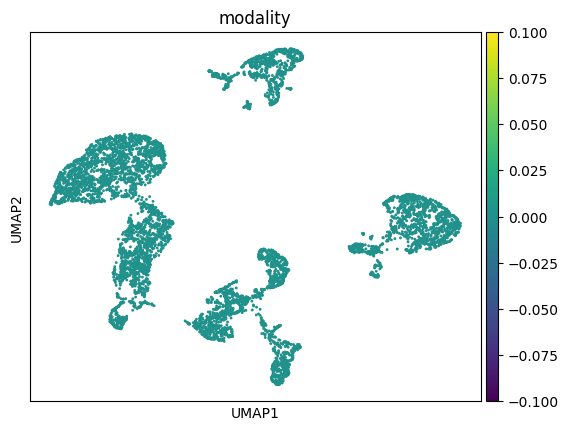

In [31]:
sc.pp.neighbors(adata_paired, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(adata_paired, min_dist=0.2)
sc.pl.umap(adata_paired, color="modality")

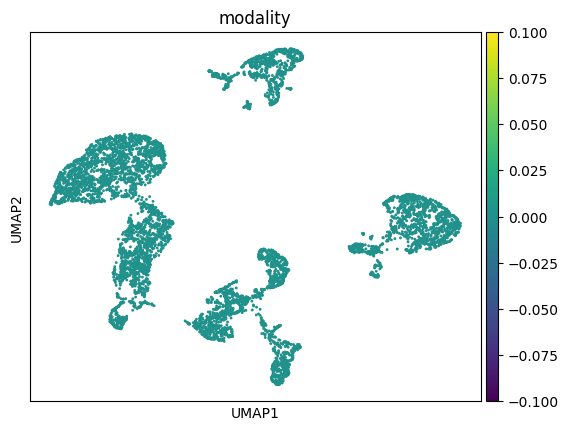

In [32]:
sc.pl.umap(adata_paired, color="modality", save="multiVI_modality.png")

In [33]:
adata_paired

AnnData object with n_obs × n_vars = 7084 × 17500
    obs: 'modality', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Chromosome', 'Range', 'Start', 'End', 'Length', 'modality'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: 'protein_expression', 'X_multivi', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/tmp/ipykernel_1083736/2382805703.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_paired)


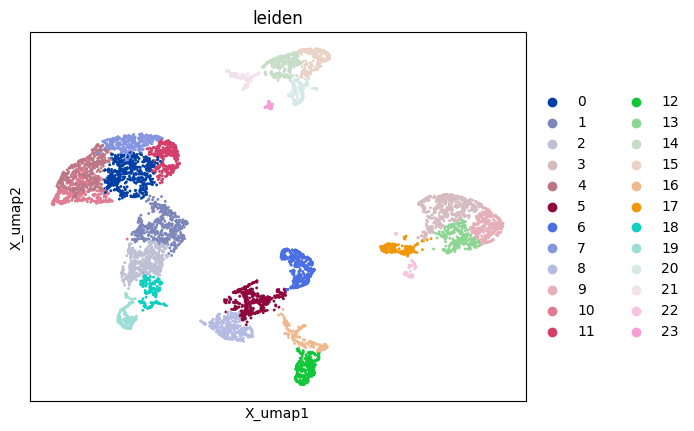

In [34]:
import leidenalg
sc.tl.leiden(adata_paired)
sc.pl.embedding(adata_paired, "X_umap", color=['leiden'], save="_TEA.png")

In [35]:
imputed_expression = model.get_normalized_expression()

In [36]:
matching_genes = adata_paired.var.index[adata_paired.var.index.str.startswith('rna:CD4')].tolist()
print(matching_genes)

['rna:CD4-0']


In [53]:
import numpy as np
gene_idx = np.where(adata_paired.var.index == "rna:PRDM16-0")[0]
adata_paired.obs["PRDM16_imputed"] = imputed_expression.iloc[:, gene_idx]
adata_paired.obs["PRDM16_imputed"]

AAACAGCCAATTAGGA-1    2.954570e-06
AAACAGCCACGTAAGG-1    8.944610e-07
AAACAGCCACTAAGAA-1    2.934360e-05
AAACATGCAAAGGCCA-1    4.803841e-06
AAACATGCAACTAACT-1    1.445829e-06
                          ...     
TTTGTTGGTCATAACG-1    1.471887e-05
TTTGTTGGTGATTACG-1    5.634793e-07
TTTGTTGGTTAGAGGG-1    2.467824e-07
TTTGTTGGTTATAGCG-1    1.635252e-05
TTTGTTGGTTTAAAGC-1    3.271863e-05
Name: PRDM16_imputed, Length: 7084, dtype: float32

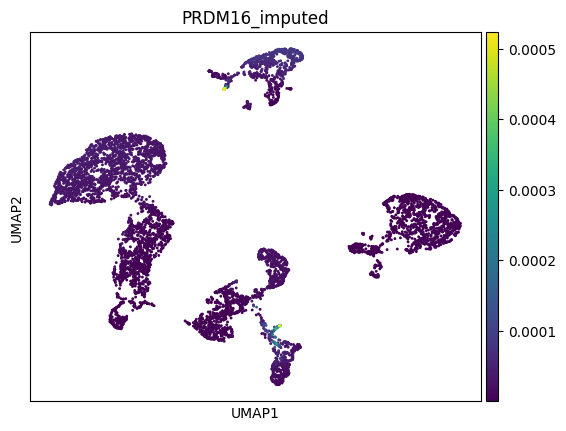

In [54]:
import anndata as ad
sc.pl.umap(adata_paired, color="PRDM16_imputed", save="_PRDM16.png")

In [46]:
adata_paired.var

,gene_ids,feature_types,genome,interval,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,Chromosome,Range,Start,End,Length,modality
rna:C1orf159-0,ENSG00000131591,Gene Expression,GRCh38,chr1:1092173-1116098,False,489,0.073907,94.046025,607.0,True,0.193740,1.546596,1.171425,NaN,NaN,NaN,NaN,NaN,0
rna:PRPF40B-0,ENSG00000110844,Gene Expression,GRCh38,chr12:49623435-49630544,False,204,0.034214,97.516133,281.0,True,0.087732,1.705311,1.823158,NaN,NaN,NaN,NaN,NaN,0
rna:LIMA1-0,ENSG00000050405,Gene Expression,GRCh38,chr12:50200846-50283546,False,230,0.037136,97.199562,305.0,True,0.097108,1.568948,1.263210,NaN,NaN,NaN,NaN,NaN,0
rna:KRT72-0,ENSG00000170486,Gene Expression,GRCh38,chr12:52601462-52601538,False,165,0.022769,97.990990,187.0,True,0.072405,1.619083,1.469077,NaN,NaN,NaN,NaN,NaN,0
rna:SOAT2-0,ENSG00000167780,Gene Expression,GRCh38,chr12:53103485-53103486,False,21,0.002679,99.744308,22.0,True,0.007792,1.594267,1.367174,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
atac:chr15:100330249-100331094-1,chr15:100330249-100331094,Peaks,GRCh38,chr15:100330249-100331094,<NA>,201,0.050530,97.552660,415.0,True,0.078476,1.501093,0.713344,chr15,100330249-100331094,100330249.0,100331094.0,845.0,1
atac:chr15:100340519-100342758-1,chr15:100340519-100342758,Peaks,GRCh38,chr15:100340519-100342758,<NA>,2579,0.901619,68.598563,7405.0,True,0.877723,1.674458,1.314895,chr15,100340519-100342758,100340519.0,100342758.0,2239.0,1
atac:chr15:100383854-100384150-1,chr15:100383854-100384150,Peaks,GRCh38,chr15:100383854-100384150,<NA>,64,0.011811,99.220748,97.0,True,0.018580,1.613064,1.417951,chr15,100383854-100384150,100383854.0,100384150.0,296.0,1
atac:chr15:98519015-98519471-1,chr15:98519015-98519471,Peaks,GRCh38,chr15:98519015-98519471,<NA>,147,0.030683,98.210155,252.0,True,0.046358,1.642326,1.493468,chr15,98519015-98519471,98519015.0,98519471.0,456.0,1


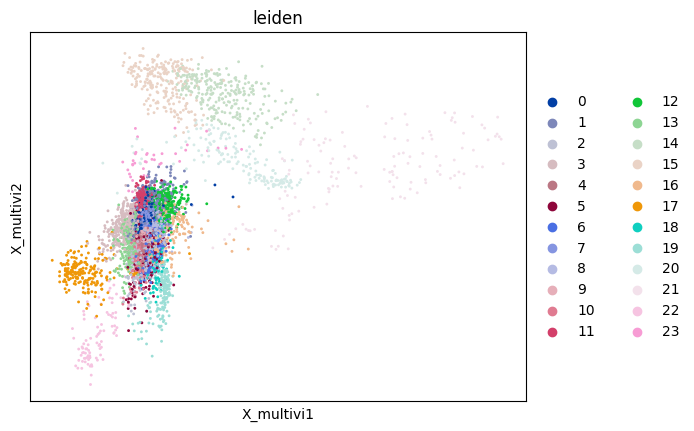

In [55]:
sc.pl.embedding(adata_paired, "X_multivi", color=['leiden'], save="_TEA.png")